# Feature selection and prediction comparison figures (message A) - Python

This notebook create the f score comparison figure.  
The methodology is inspired from the article :  
"_Support vector machines combined with feature selection for
breast cancer diagnosis_".



In [111]:
# require general data science pacakges (machine learning, pandas, etc)
import numpy as np
import pandas as pd
import os
import sys

# machine learning
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import time
import math

from sklearn import metrics
import time
import matplotlib.pyplot as plt
from matplotlib import use
import seaborn as sns
from datetime import date

In [112]:
def f_score(X, y, val1=2, val2=4):
    """
    function that compute F-score.
    input :
        - X is the feature
        - y is the ouput variable
        - val1 and val2 are the two modalities

    output :
        - f score result of the variable X
    """
    X1 = X[y == val1]
    X2 = X[y == val2]
    mean_X = X.mean()
    mean_X1 = X1.mean()
    mean_X2 = X2.mean()
    n_X1 = len(X1)
    n_X2 = len(X2)
    sum_X1 = ((X1 - mean_X1) ** 2).sum()
    sum_X2 = ((X2 - mean_X2) ** 2).sum()
    return ((mean_X1 - mean_X) ** 2 + (mean_X2 - mean_X) ** 2) / (
        ((1 / (n_X1 - 1)) * sum_X1) + ((1 / (n_X2 - 1)) * sum_X2)
    )

In [3]:
def unique_SVM_model(X_train, y_train, X_test, y_test, order, parameters, nb_var):
    """
    Train a SVM model and found best parameters
    input :
        - X_train, y_train, X_test, y_test: typical datasets for training a ML model
        - order : the variables importance order
        - parameters :
        - nb_var : the number of feature selected for the model

    output :
        - best_params :parameters of the best model
        - cm: confusion matrix of the best model
        - df_res : performance of prediction results
        - df_roc: dataframe to draw ROC curve.
    """
    svc = SVC(probability=True)
    clf = GridSearchCV(svc, parameters, cv=10, n_jobs=11)
    clf.fit(X_train[order[0:nb_var]], y_train)
    best_params = clf.best_params_
    cm = pd.crosstab(y_test, clf.predict(X_test[order[0:nb_var]]))
    TP = cm.iloc[0, 0]
    TN = cm.iloc[1, 1]
    FP = cm.iloc[0, 1]
    FN = cm.iloc[1, 0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) * 100
    specificity = TN / (TN + FP) * 100
    ppv = TP / (TP + FP) * 100
    npv = TN / (TN + FN) * 100
    auc = metrics.roc_auc_score(
        y_train, clf.predict_proba(X_train[order[0:nb_var]])[:, 1]
    )
    fpr, tpr, thresholds = metrics.roc_curve(
        y_train, clf.predict_proba(X_train[order[0:nb_var]])[:, 1]
    )
    df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
    df_res = pd.DataFrame(
        [accuracy, sensitivity, specificity, ppv, npv, auc],
        index=["acc", "sens", "spec", "ppv", "npv", "auc"],
    )
    return (best_params, cm, df_res, df_roc)

In [113]:
def SVM_model(X_train, y_train, X_test, y_test, order, parameters):
    """
    Train SVM models with different feature size.
    input :
        - X_train, y_train, X_test, y_test: typical datasets for training a ML model
        - order : the variables importance order
        - parameters :

    output :
        - best_params :parameters of the best model
        - df_res : performance of prediction results
    """
    val = []
    best_params = []
    accuracy = []
    sensitivity = []
    specificity = []
    ppv = []
    npv = []
    auc = []
    for i in range(1, len(order) + 1):
        svc = SVC(probability=True)
        clf = GridSearchCV(svc, parameters, cv=10)
        clf.fit(X_train[order[0:i]], y_train)
        best_params.append(clf.best_params_)
        cm = pd.crosstab(y_test, clf.predict(X_test[order[0:i]]))
        TP = cm[0][0]
        TN = cm[1][1]
        FP = cm[0][1]
        FN = cm[1][0]
        accuracy.append((TP + TN) / (TP + TN + FP + FN))
        sensitivity.append(TP / (TP + FN) * 100)
        specificity.append(TN / (TN + FP) * 100)
        ppv.append(TP / (TP + FP) * 100)
        npv.append(TN / (TN + FN) * 100)
        auc.append(
            metrics.roc_auc_score(y_train, clf.predict_proba(X_train[order[0:i]])[:, 1])
        )
        val.append(str(i) + "_vars")
    df_res = pd.DataFrame(
        {
            "acc": accuracy,
            "sens": sensitivity,
            "spec": specificity,
            "ppv": ppv,
            "npv": npv,
            "auc": auc,
        },
        index=val,
    )
    return (best_params, df_res)

## Data loading

In [114]:
# Import the color df containing colors combination
colors = pd.read_csv("../../color.csv", index_col=0)

In [115]:
file_data = "../../datasets/"

In [116]:
# we load original data and avatar data with k = 20
data = pd.read_csv(file_data + "WBCD/breast_cancer_wisconsin.csv")
data = data.drop("Sample_code_number", axis=1)
avatar = pd.read_csv(file_data + "/WBCD/breast_cancer_wisconsin_avatarized_k20.csv")

In [117]:
data.Class = data.Class.replace(2, 0)
data.Class = data.Class.replace(4, 1)

avatar.Class = avatar.Class.replace(2, 0)
avatar.Class = avatar.Class.replace(4, 1)

In [118]:
save = False

### Parameters

In [119]:
# Parameters map for the SVM model
map_object = map(lambda val: 2 ** val, list(range(-15, 3)))
gamma_list = list(map_object)

map_object = map(lambda val: 2 ** val, list(range(-5, 16)))
C_list = list(map_object)

logC_list = [math.log(y, 2) for y in C_list]


parameters = {"kernel": ["rbf"], "C": C_list, "gamma": gamma_list}

## Analysis computation 

We are here perform 100 different train/test 70/30 split. We split the original dataset and the avatarized dataset with the same stratification.

For each split : 
- We first compute F_score for each feature with the f_score function.
- We then train a SVM model the 5 best features selected.

The following cell is time consuming (more than 40 minutes), so we save the results in a dataframe.   
Thus, the execution is not required.


In [120]:
# load results
df_scores_70 = pd.read_csv("../../datasets/results_df/WBCD_f-score_variouSplit.csv")
df_res_70 = pd.read_csv("../../datasets/results_df/WBCD_perf_variouSplit.csv")


df_scores_70.type = df_scores_70.type.replace("Original", "Original (AUC = 0.99)")
df_scores_70.type = df_scores_70.type.replace("Avatar", "Avatar (AUC = 0.99)")

## Graphes F-scores

We are here performing the F-score figure, with confidence intervals of the mean (95%).

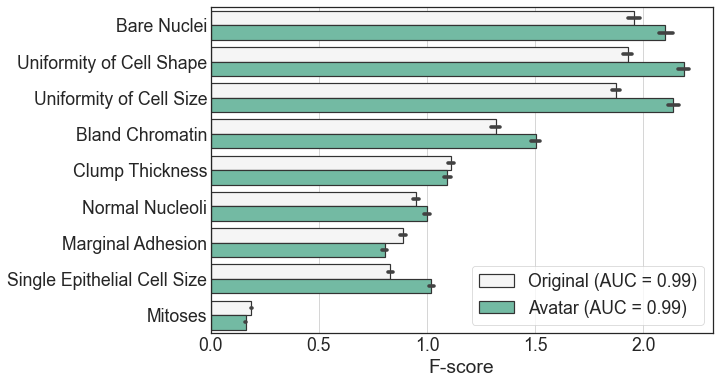

In [121]:
# Figure context
paper_rc = {"lines.linewidth": 2, "lines.markersize": 10}
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2, rc=paper_rc)
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.25
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Helvetica"]

    fig = plt.figure(figsize=(9, 6))  # create a figure object
    ax1 = fig.add_subplot()

# add barplot with confidence intervals.
ax = sns.barplot(
    x="F-score",
    y="feature",
    hue="type",
    data=df_scores_70,
    order=[
        "Bare Nuclei",
        "Uniformity of Cell Shape",
        "Uniformity of Cell Size",
        "Bland Chromatin",
        "Clump Thickness",
        "Normal Nucleoli",
        "Marginal Adhesion",
        "Single Epithelial Cell Size",
        "Mitoses",
    ],
    ci=95,
    linewidth=1.2,
    edgecolor=".2",
    # color by avatar and original colors
    palette=(colors.loc["original", "color"], colors.loc["avatar", "color"]),
)

ax.set(ylabel="")

plt.legend(title="", loc="lower right")

plt.savefig(
    "../../figure/WBCD_f-score_70_30.svg", bbox_inches="tight", format="svg", dpi=600
)

## Supplemental table
We compute prediction performance for each split for avatar and original data. 
Results are presented as a table

In [124]:
res_mean = df_res_70.groupby(["perf", "type"]).agg({"0": ["mean", "std"]})
res_mean = res_mean.reset_index()
res_mean.columns = res_mean.columns.droplevel(0)
res_mean = res_mean.rename_axis(None, axis=1)
res_mean.columns = ["result", "type", "mean", "std"]


res_mean = res_mean.pivot(index="result", columns="type", values=["mean", "std"])
res_mean.columns.names = ["calc", "type"]
res_mean = res_mean.stack(level=[0])
res_mean =round(res_mean, 2)

mean = res_mean.loc[(slice(None), 'mean'), :]
std = res_mean.loc[(slice(None), 'std'), :]
mean = mean.reset_index(drop = False)
std = std.reset_index(drop = False)

mean.drop(labels = [ "calc"], axis = 1,  inplace = True)
std.drop(labels = [ "calc"], axis = 1,  inplace = True)

res = pd.concat([mean, std], axis=1)
res.columns = ['result', 'Avatar', 'Original', 'result_2', 'Avatar_std', 'Original_std']
res.drop(labels = [ "result_2"], axis = 1,  inplace = True)


res['Avatar'] = res.Avatar.astype(str) + ' - ' + res.Avatar_std.astype(str)
res['Original'] = res.Original.astype(str) + ' - ' + res.Original_std.astype(str)

res.drop(columns = ["Avatar_std", "Original_std"], inplace = True)
res


,result,Avatar,Original
0,acc,0.97 - 0.01,0.97 - 0.01
1,auc,1.0 - 0.0,0.99 - 0.0
2,npv,96.07 - 2.77,96.08 - 2.88
3,ppv,97.6 - 1.62,96.85 - 1.35
4,sens,97.87 - 1.49,97.88 - 1.51
5,spec,95.69 - 2.83,94.35 - 2.28


In [110]:
res.to_csv("../../datasets/results_df/supplemental_table_WBCD.csv", index= False)